# Getting started

**HQS Spectrum Tools** is comprised of the Python packages `hqs-nmr-parameters` and `hqs-nmr`. `hqs-nmr-parameters` is a database containing NMR parameters for a large number of molecules and will be introduced in the [second tutorial](2_hqs_nmr_parameters_introduction.ipynb). In this tutorial we want to focus on `hqs-nmr` and how to use it for the evaluation of NMR spectra. We will use convenience functions, which will automatically choose a discretized frequency grid, for which we need direct access to the NMR parameters. A simple way to proceed is to store NMR parameters in a `YAML` file. Such an input file can be found in the same folder as this tutorial for the molecule propane. You can learn how to create such a file [here](https://docs.cloud.quantumsimulations.de/hqs-spectrum-tools/subfolder/database/text_input.html), but we advice you to first read through this and the [next](2_hqs_nmr_parameters_introduction.ipynb) tutorial to learn about the most important aspects of **HQS Spectrum Tools**.

Note that in more advanced use cases, you might end up directly with an NMR spin Hamiltonian in a `struqture` format. In this case, you can still use the **HQS Spectrum Tools** solver backend to obtain the spectrum, which is discussed in [tutorial 7](./7_spectrum_from_struqture_hamiltonian.ipynb). 

Let's start by first importing all necessary modules.

In [1]:
# NMR
from hqs_nmr.calculate import calculate_spectrum
from hqs_nmr_parameters import read_parameters_yaml
from hqs_nmr.datatypes import to_json, from_json, NMRResultSpectrum1D, NMRCalculationParameters
from hqs_nmr import conversion
from hqs_nmr.visualization import plot_spectrum

# external modules
import matplotlib.pyplot as plt
import numpy as np

# only to plot molecular structures (optional)
from rdkit import Chem

# Can be installed via HQStage and gives the plots a nice layout. This is an optional dependency.
import HQStyle
HQStyle.import_all()

While we want to focus on `hqs-nmr`, we will still use a convenience function provided by `hqs-nmr-parameters` to read the **YAML** input file and to turn it into a format compatible with `hqs-nmr`.

In [2]:
molecule_parameters = read_parameters_yaml("propane.yaml")

If you want to make sure you have the correct molecule, you can check the structure of your molecule using an external package called [RDKit](https://www.rdkit.org/docs/GettingStartedInPython.html). For our example, the molecular structure was just defined via a **SMILES** string. Alternatively, also a **Molfile** could be provided, which you will see in the [third tutorial](3_customization.ipynb).

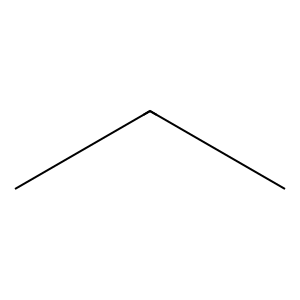

In [3]:
smiles_string = molecule_parameters.structures["SMILES"].content
molecule_image_info = Chem.MolFromSmiles(smiles_string)
Chem.Draw.MolToImage(molecule_image_info)

To run an NMR spectrum calculation we first have to define an object of the dataclass `NMRCalculationParameters`. This data class stores a lot of attributes to customize a specific calculation, which will be discussed in the other example notebooks. However, in the simplest case, the only required option is the applied magnetic field in units of Tesla. If we know the spectrometer frequency (i.e., the frequency at which a proton comes into resonance under an applied magnetic field), we can convert it.

In [4]:
# The function assumes hydrogen as a reference isotope. This can be changed using the
# keyword reference_isotope.
frequency_MHz = 500
field_T = conversion.frequency_MHz_to_field_T(frequency_MHz)

calculation_parameters = NMRCalculationParameters(field_T=field_T)

Now to evaluate the NMR spectrum, we simply have to do a single function call supplying the two objects we just obtained as input:

In [5]:
result_spectrum = calculate_spectrum(molecule_parameters, calculation_parameters)

By default we call internally a solver that performs a clustering of the molecule. While it is in general an approximate solver, it is very accurate, and gives very reliable results especially for the case of high-field NMR. The calculations is also sped up by exploiting the $I^z$ conservation of the NMR Hamiltonian. 
Furthermore, in case the number of spins is smaller than some maximum cluster size, which by default is set to 12, the method is exact. We will show in the [third tutorial](3_customization.ipynb) how to adjust this threshold.
Check out the [documentation](https://docs.cloud.quantumsimulations.de/hqs-spectrum-tools/subfolder/background/solver.html) and the next tutorials for further details on this method.

From the function call, we get an object of the data class `NMRResultSpectrum1D`. We can print its attributes as follows:

In [6]:
result_spectrum.model_dump().keys()

dict_keys(['molecule_parameters', 'calculation_parameters', 'spectrum'])

The attributes `molecule_parameters` and `calculation_parameters` are the input parameters we defined earlier. They are included in the result, as this allows us to quickly store all information concerning a specific NMR spectrum calculation in a `JSON` file, as will be shown later in this notebook.

What we are now interested in though is the attribute `spectrum`, which stores all the information on the calculated spectrum:

In [7]:
spectrum = result_spectrum.spectrum
spectrum.model_dump().keys()

dict_keys(['omegas_ppm', 'spin_contributions', 'fwhm_ppm'])

Here, `fwhm_ppm` is an artificial broadening used to mimic the effects of noise and is estimated internally. We will come back to it in the [third tutorial](3_customization.ipynb). The frequencies (or chemical shifts, in ppm) are stored in `omegas_ppm`, while `spin_contributions` contains the individual spin contributions to the spectral function as a $N_{\text{spins}} \times N_{\omega}$ array. Here $N_{\text{spins}}$ is the number of spins in the molecule and $N_{\omega}$ the number of frequency values. Analyzing the individual contributions rather than the full spectrum can be helpful when investigating which feature in the spectral function is associated with which spin. Let's plot the contributions associated with spins 0 and 4:

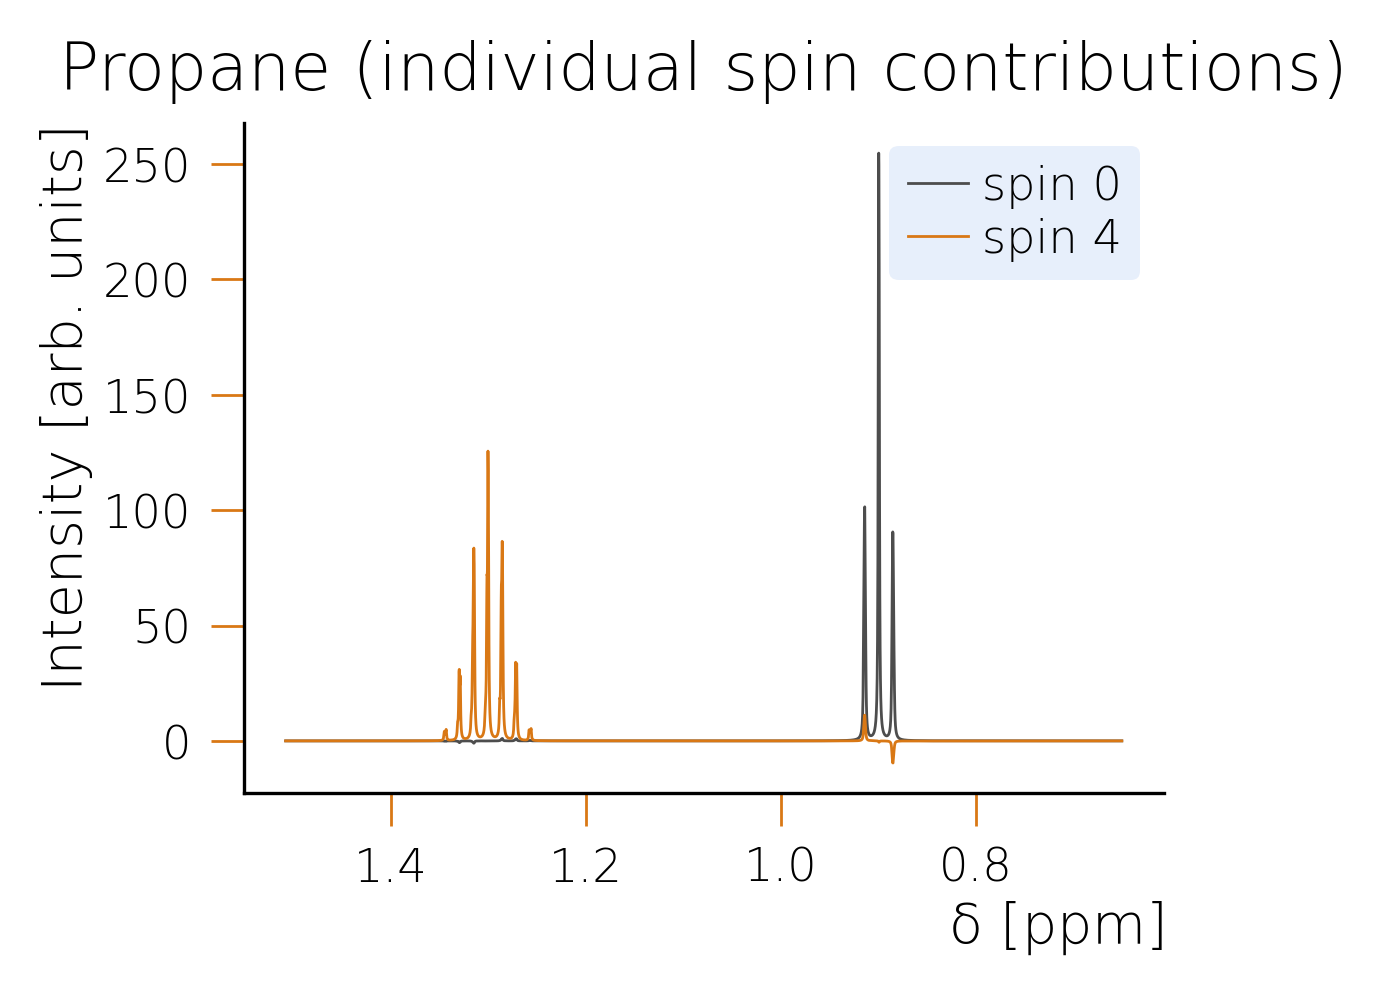

In [8]:
plt.plot(spectrum.omegas_ppm, spectrum.spin_contributions[0, :], label="spin 0", linewidth=0.5)
plt.plot(spectrum.omegas_ppm, spectrum.spin_contributions[4, :], label="spin 4", linewidth=0.5)
plt.title("Propane (individual spin contributions)")
plt.xlabel("$\\delta$ [ppm]")
plt.ylabel("Intensity [arb. units]")
plt.legend()

# Invert the frequency axis as is standard in NMR spectroscopy.
plt.gca().invert_xaxis()

plt.show()

As you can see, in this case the two spins are associated with completely different multiplets. Note also that there are negative values in the spectrum. This is because only the full spectral function has to be completely positive. To plot it, we can simply sum the values of all contributions as follows:

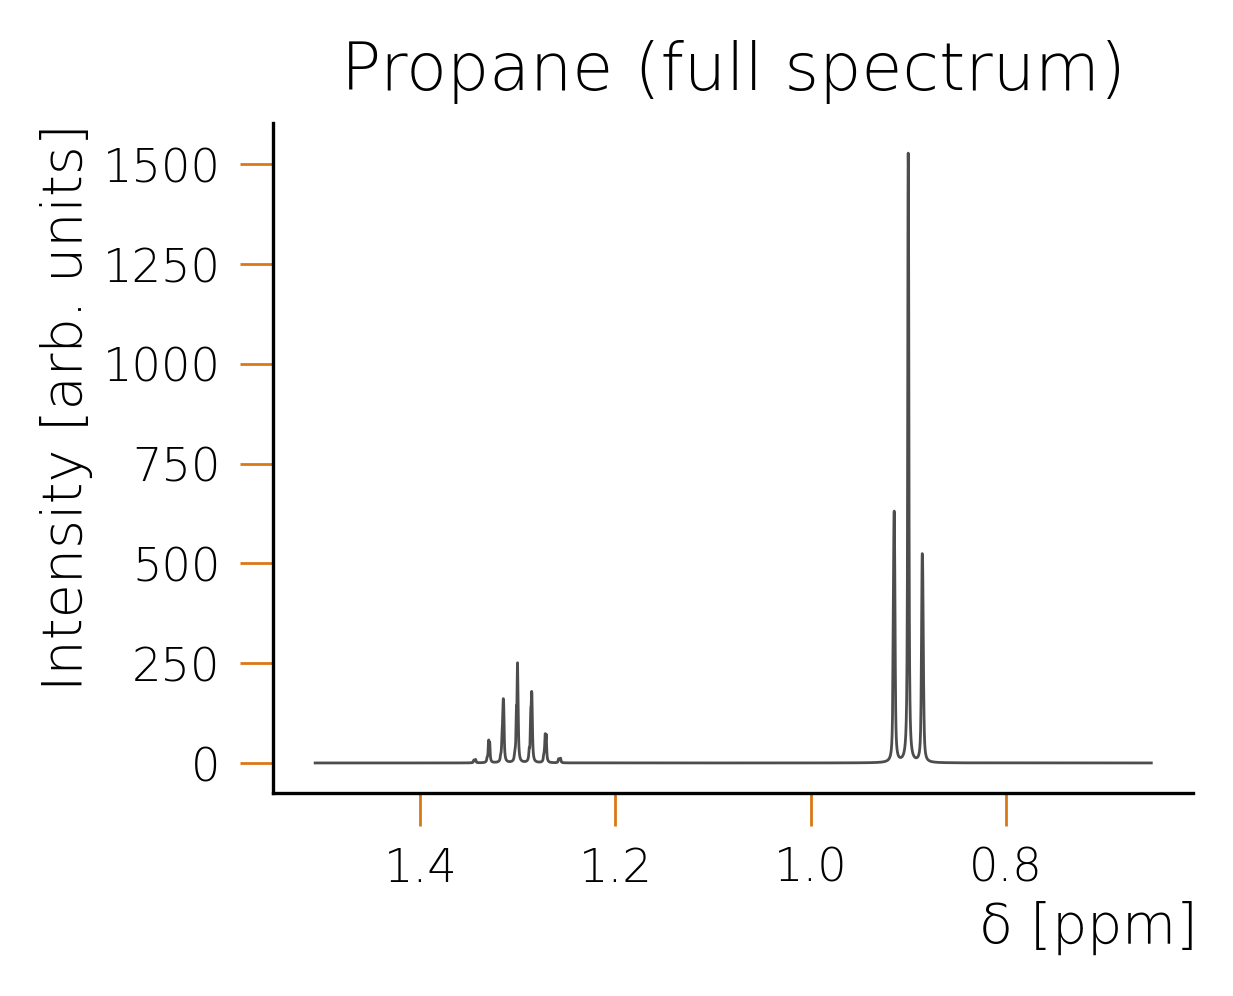

In [9]:
plt.plot(spectrum.omegas_ppm, np.sum(spectrum.spin_contributions, axis=0), linewidth=0.5)
plt.xlabel("$\\delta$ [ppm]")
plt.ylabel("Intensity [arb. units]")
plt.title("Propane (full spectrum)")
plt.gca().invert_xaxis()
plt.show()

And as mentioned, the full spectral function is indeed completely positive.

If you don't want to worry about summing up the individual contributions, you can also simply use a convenience function.

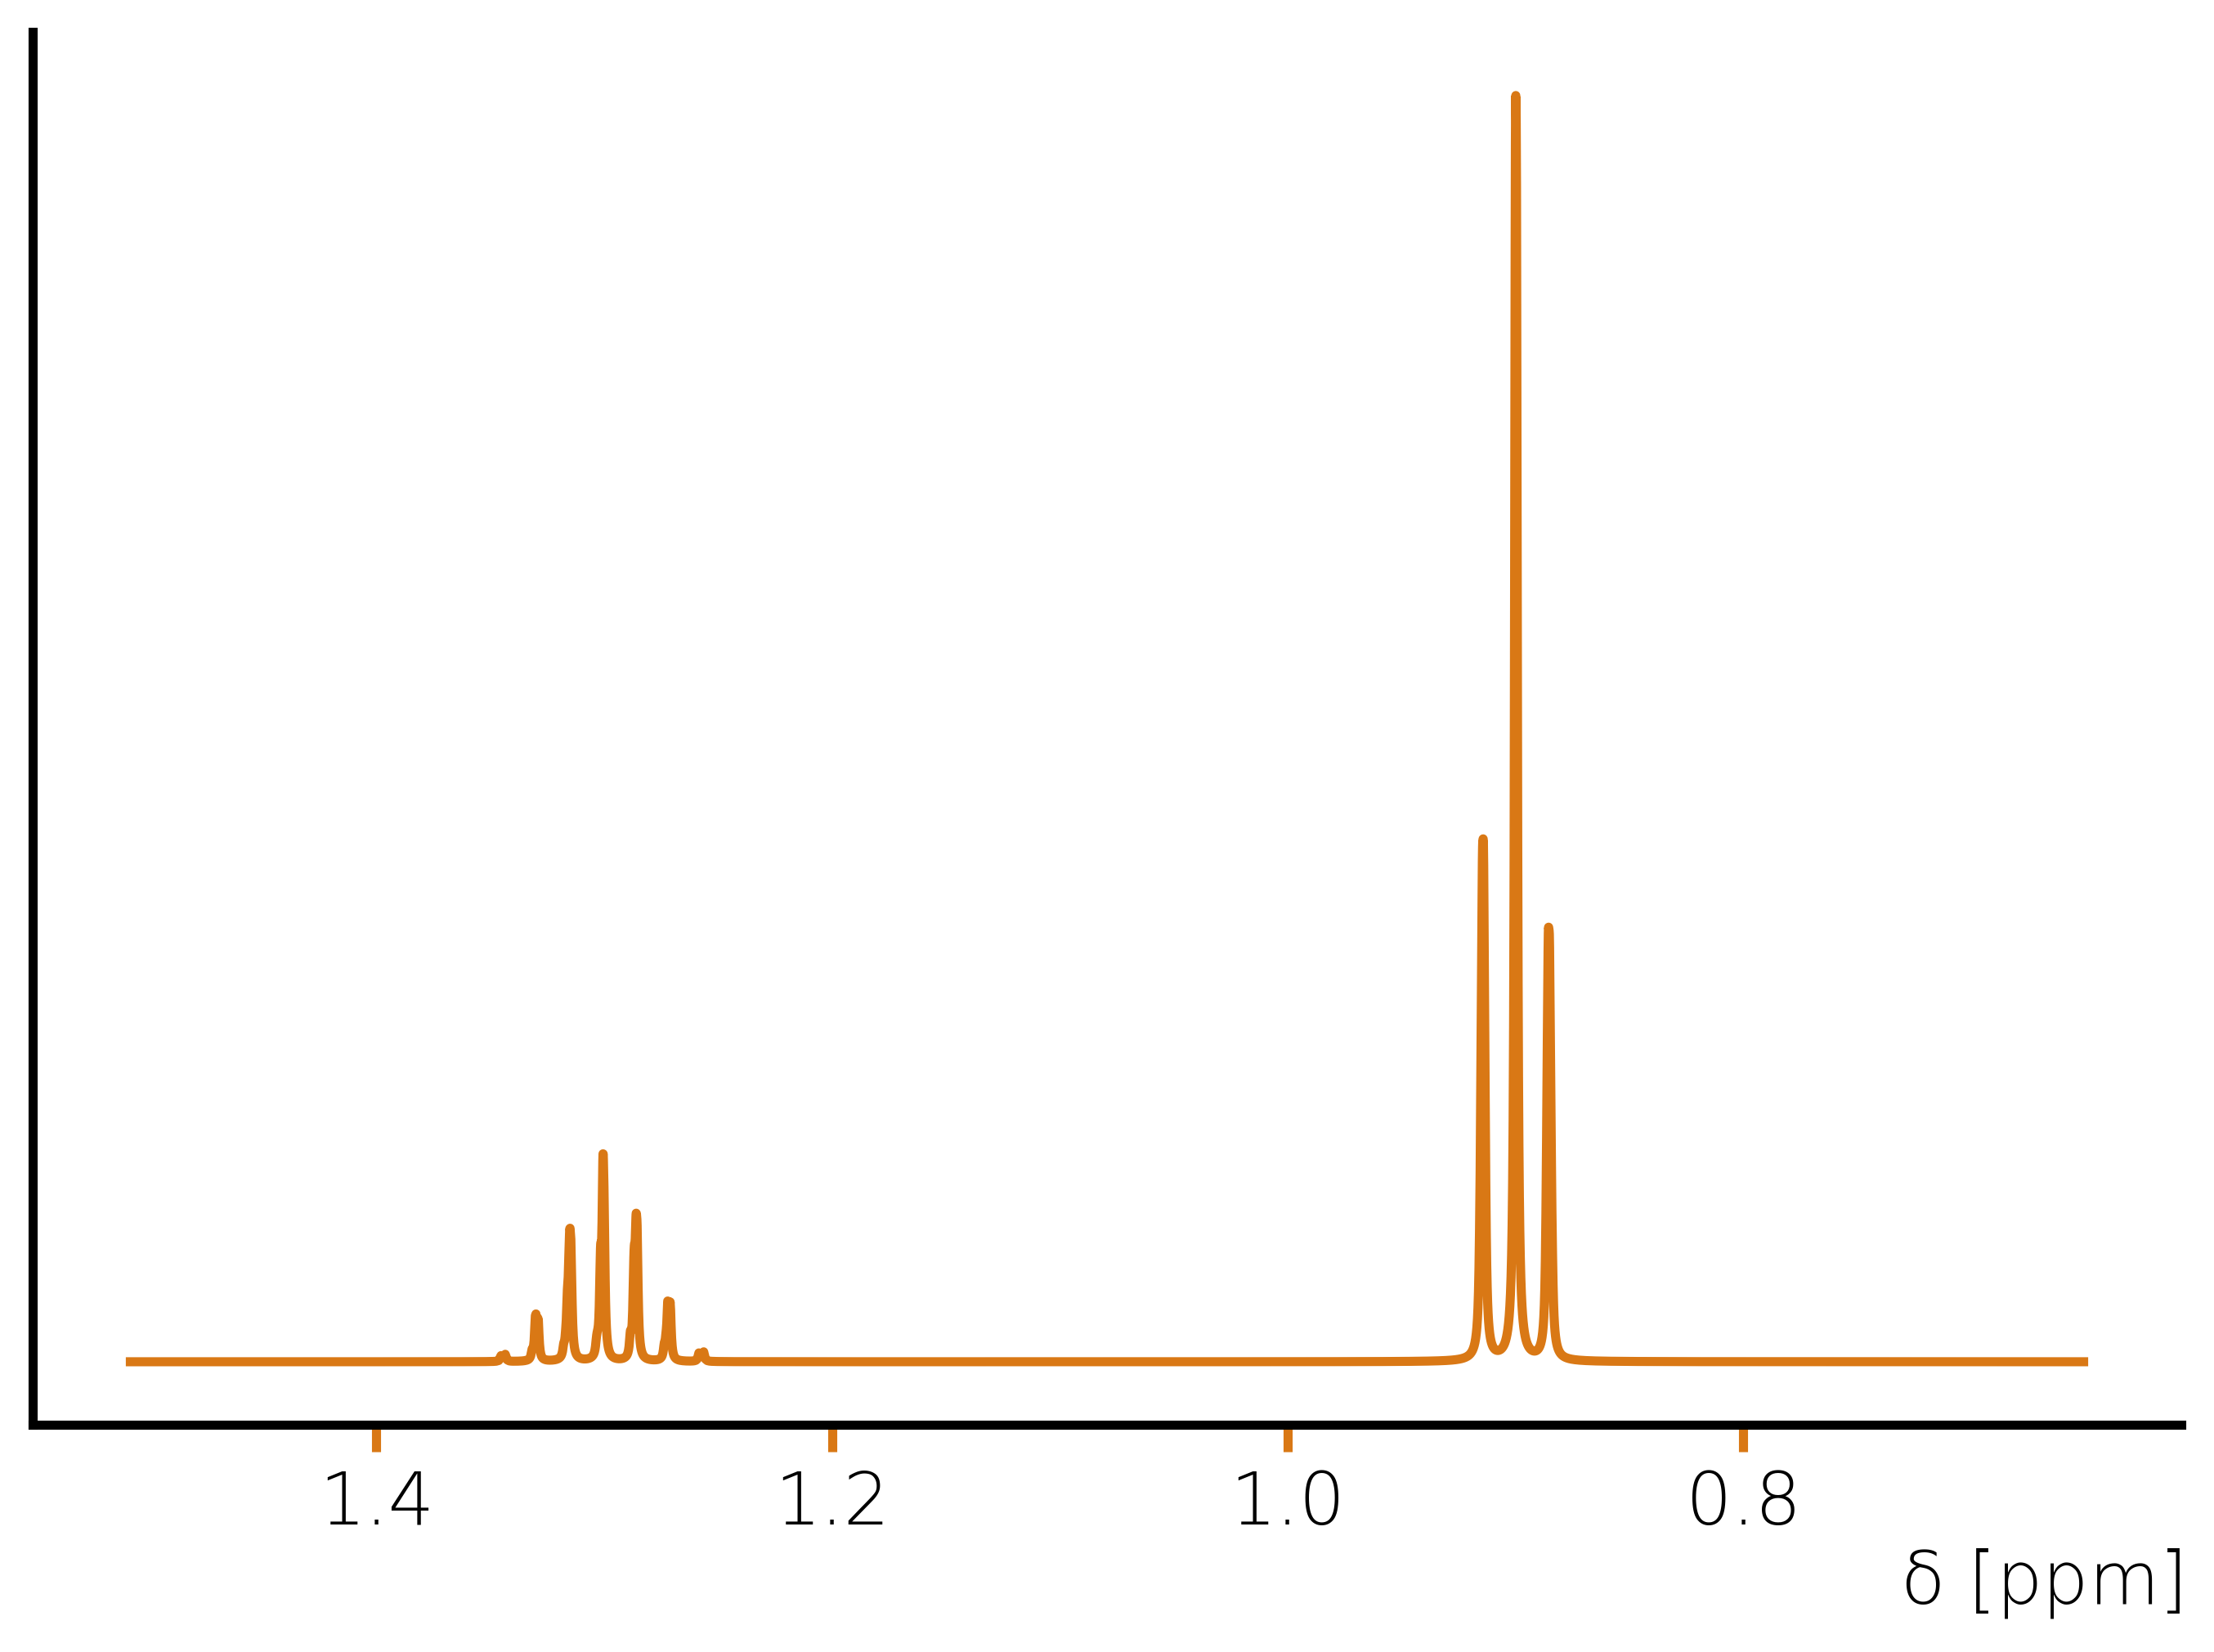

In [10]:
plot_spectrum(spectrum)

Finally, as mentioned above we can store the result of our calculation using a function called `to_json`. It takes as input any of the data classes defined in `hqs_nmr.datatypes` and a desired filename and saves the result in **JSON** format.

In [11]:
to_json(result_spectrum, "result_spectrum_propane.json")

We could now load the data again using the inverse function `from_json`. It takes as input the datatype of the class we want to load and the file name:

In [12]:
result_spectrum_reloaded = from_json(NMRResultSpectrum1D, "result_spectrum_propane.json")

This is already everything you need to know to get started with your first NMR spectrum calculations. In the following tutorials, we are going to discuss some customization options, go into details on the `hqs-nmr-parameters` database, will give a few more details on the different solver strategies, and discuss some special cases.